### Estimating Granger Causality usign spectral methods

In [2]:
import numpy                                 as np
import matplotlib.pyplot                     as plt
import pygc.spectral_analysis.time_frequency as tf
import pygc.non_parametric
import pygc.granger
import pandas                                as pd
from   tqdm                                  import tqdm

#### Toy model from Dhamala et. al. 2008

Coupled auto-regressive models.

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

In [3]:
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    ''' 
        AR model from Dhamala et. al.
    '''
    
    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N]) 
    Y = np.random.random([Trials, N]) 

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in range(Trials):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([Trials,2,N]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 

    return Z

### 1. Stationary coupling 

In this case $C(t) = 0.25$ $\forall$ $t$.

In [3]:
N  = 5000      # Number of observations
Fs = 200       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 10    # Number of trials
freqs  = np.arange(1,100,.1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

In [4]:
# Generating data
X = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=None, cov=cov)

In [5]:
W = tf.wavelet_transform(data = X, fs = Fs, freqs = freqs, n_cycles = freqs/2,
                         time_bandwidth = None, delta = 1, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   11.4s finished


In [6]:
# Auto- and cross-spectra
S11 = W[:,0,:,:] * np.conj(W[:,0,:,:])
S22 = W[:,1,:,:] * np.conj(W[:,1,:,:])
S12 = W[:,0,:,:] * np.conj(W[:,1,:,:])
S21 = W[:,1,:,:] * np.conj(W[:,0,:,:])
# Spectral matrix
S    = np.array([ [S11, S12],
                  [S21, S22]]) / N
# Average over trials
S_mu = S.mean(axis = 2)

Since the coupling between $X_{1}$ and $X_{2}$ is static the information in the time-axis is redundant and we can average the spectra over time.

In [7]:
S_mu = S_mu.sum(axis=-1) * dt

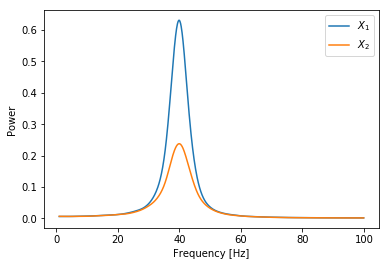

In [8]:
plt.plot(freqs, S_mu[0,0].real, label = r'$X_{1}$')
plt.plot(freqs, S_mu[1,1].real, label = r'$X_{2}$')
plt.ylabel('Power')
plt.xlabel('Frequency [Hz]')
plt.legend()

In [9]:
Snew, Hnew, Znew = pygc.non_parametric.wilson_factorization(S_mu, freqs, Fs, Niterations=30, verbose=True)
Ix2y, Iy2x, Ixy  = pygc.granger.granger_causality(Snew, Hnew, Znew) 

Err = 0.4001186057486451
Err = 0.18600962533383347
Err = 0.07878562502218636
Err = 0.02116690920428112
Err = 0.0018051692442704866
Err = 0.00030632863032740916
Err = 0.00015119635065456632
Err = 7.559281796065912e-05
Err = 3.779645143720014e-05
Err = 1.8898326106947216e-05
Err = 9.449363856957336e-06
Err = 4.725083486454894e-06
Err = 2.3633446677927943e-06
Err = 1.1832773615713486e-06
Err = 5.94837770996737e-07
Err = 3.0374837329638745e-07
Err = 1.639156757826593e-07
Err = 1.1103206971005792e-07
Err = 1.0346459782528503e-07
Err = 1.0300561560594481e-07
Err = 1.0300372494676098e-07
Err = 1.0300372498491693e-07
Err = 1.0300372500457551e-07
Err = 1.0300372501547268e-07
Err = 1.0300372501941478e-07
Err = 1.0300372502057404e-07
Err = 1.0300372501853709e-07
Err = 1.0300372501786315e-07
Err = 1.0300372501639344e-07
Err = 1.0300372501733634e-07


Text(0.5, 0, 'Frequency [Hz]')

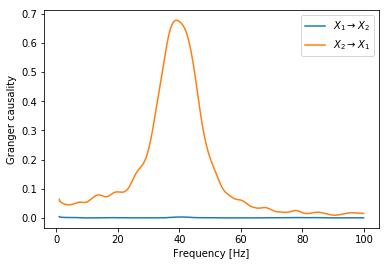

In [10]:
plt.plot(freqs, Ix2y, label = r'$X_{1}\rightarrow X_{2}$')
plt.plot(freqs, Iy2x, label = r'$X_{2}\rightarrow X_{1}$')
plt.legend()
plt.ylabel('Granger causality')
plt.xlabel('Frequency [Hz]')

### 1. Time-varying coupling 

In this case the couplig will vary with time, more specificaly $C(t) = 0.25$ for $t < 2.25$ s.

In [11]:
#
N = 900
#
freqs  = np.arange(5,100,1) # Frequency axis
# Generating data
X = ar_model_dhamala(N=900, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=2.25, cov=cov)

In [12]:
W = tf.wavelet_transform(data = X, fs = Fs, freqs = freqs, n_cycles = freqs/2,
                         time_bandwidth = None, delta = 1, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.5s finished


In [13]:
# Auto- and cross-spectra
S11 = W[:,0,:,:] * np.conj(W[:,0,:,:])
S22 = W[:,1,:,:] * np.conj(W[:,1,:,:])
S12 = W[:,0,:,:] * np.conj(W[:,1,:,:])
S21 = W[:,1,:,:] * np.conj(W[:,0,:,:])
# Spectral matrix
S    = np.array([ [S11, S12],
                  [S21, S22]]) / N
# Average over trials
S_mu = S.mean(axis = 2)

In this case we keep the time dimension

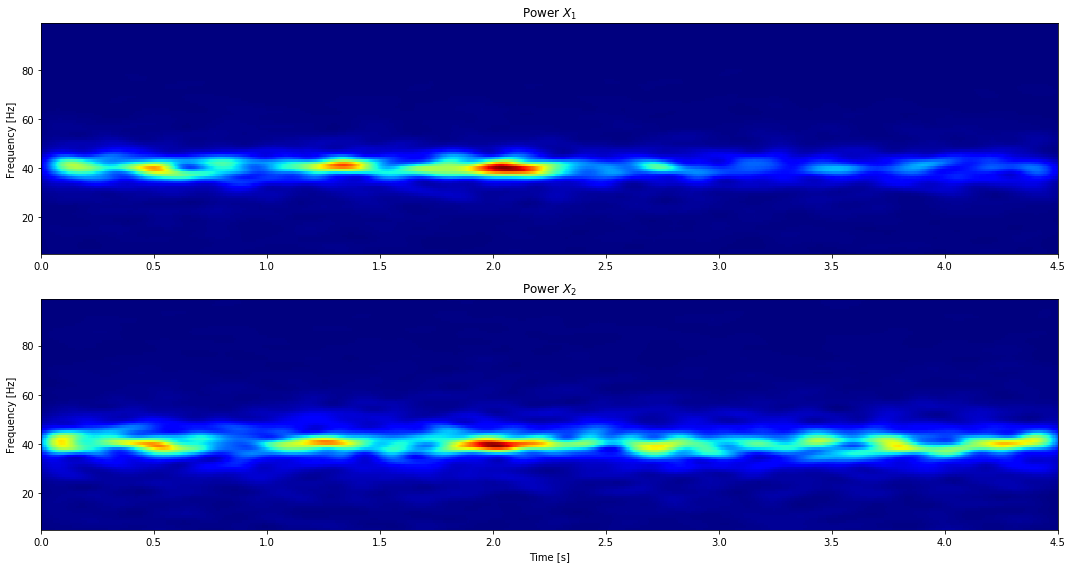

In [19]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.imshow(S_mu[0,0].real, aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs,freqs[0],freqs[-1]])
plt.title(r'Power $X_{1}$')
plt.ylabel('Frequency [Hz]')
plt.subplot(2,1,2)
plt.imshow(S_mu[1,1].real, aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs,freqs[0],freqs[-1]])
plt.title(r'Power $X_{2}$')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.tight_layout()

In [15]:
GC = np.zeros([2, len(freqs), S_mu.shape[-1]])
for t in tqdm( range(S_mu.shape[-1]) ):
    Snew, Hnew, Znew = pygc.non_parametric.wilson_factorization(S_mu[:,:,:,t], freqs, Fs, Niterations=30, verbose=False)
    GC[0,:,t], GC[1,:,t], _  = pygc.granger.granger_causality(S_mu[:,:,:,t], Hnew, Znew) 

100%|██████████| 900/900 [05:56<00:00,  2.52it/s]


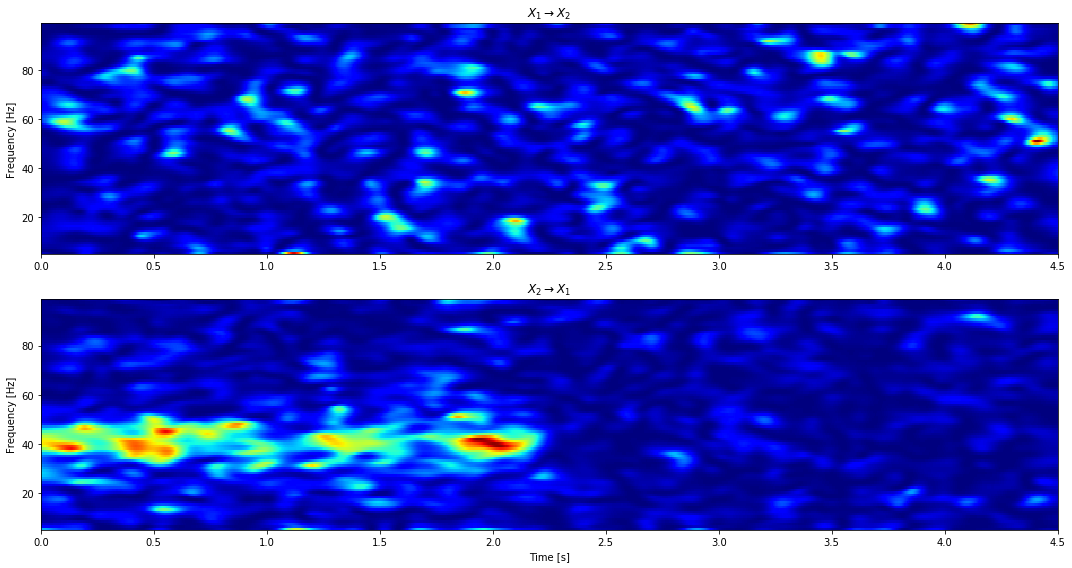

In [20]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.imshow(GC[0].real, aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs,freqs[0],freqs[-1]])
plt.title(r'$X_{1}\rightarrow X_{2}$')
plt.ylabel('Frequency [Hz]')
plt.subplot(2,1,2)
plt.imshow(GC[1].real, aspect='auto', cmap='jet', origin='lower', extent=[0,N/Fs,freqs[0],freqs[-1]])
plt.title(r'$X_{2}\rightarrow X_{1}$')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.tight_layout()

In [7]:
pop_name    = ['L23e','L4e','L5e','L6e']
rseed       = np.arange(1000,11000,1000)
Ntrials     = len(rseed)
# dirname     = './tc3_L6ebg8.0_cth1.0_L5IB4/'#'./cortex_L5IB4/'
dirname     = 'data/'
data        = pd.read_csv(dirname+'spike_activity_seed10000_thc40.0_cth40.0.dat')

# X = Data which you want to estimate GC, dimension must be [Nvariables, Nobservations, Ntrials]
X           = np.zeros((len(pop_name),data.shape[0],Ntrials))

for trial in range(Ntrials):
    #data        = pd.read_csv(dirname+'spike_activity_g7.0_bg6.0_seed'+str(rseed[trial])+'.dat')
    # spike_activity_seed10000_thc40.0_cth40.0.dat
    data        = pd.read_csv(dirname+'spike_activity_seed'+str(rseed[trial])+'_thc40.0_cth40.0.dat')
    for pop in range(len(pop_name)):
        X[pop,:,trial] = data[pop_name[pop]]

In [8]:
X.shape

(4, 10000, 10)

In [9]:
from pygc.parametric import *

In [10]:
m_values = np.arange(2,100,2, dtype=int)
AIC      = []
for j in tqdm( range(len(m_values)) ):
    SIG = np.zeros([X.shape[0],X.shape[0]])
    for i in range(X.shape[-1]):
        _, aux = YuleWalker(X[:,:,1], m_values[j], maxlags=100)
        SIG += aux
    AIC.append( aic(X.shape[0],m_values[j],X.shape[1],SIG) )

100%|██████████| 49/49 [02:13<00:00,  2.73s/it]


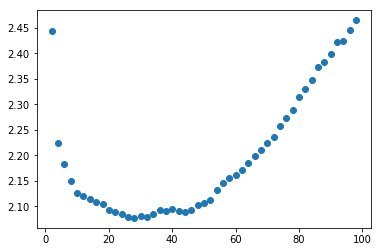

In [11]:
plt.plot(m_values,np.array(AIC), 'o') 

In [26]:
import pygc as pyGC

In [37]:
m = m_values[np.argmin(AIC)]
T = X.shape[1] / Fs
f = np.linspace(1/T,Fs/2-1/T,X.shape[1]/2+1)

/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
Nvars  = X.shape[0]  # For now I recommend Nvars to be equal two.
N      = X.shape[1]
Trials = X.shape[2]
Fs = 1000.0# Sample frequency of the data
AR  = np.zeros([m,Nvars,Nvars])
SIG = np.zeros([Nvars,Nvars])
for T in range(X.shape[-1]):
    aux1, aux2 = YuleWalker(X[:,:,T], m, maxlags=100)
    AR  += aux1/Trials
    SIG += aux2/Trials

In [40]:
H, S = pygc.parametric.compute_transfer_function(AR, SIG, f, Fs)

Estimating pairwise Granger causalities:
Estimating conditional Granger causalities:
Err = 963.6368055838094
Err = 481.82072676119435
Err = 240.82335704377215
Err = 120.30482794700089
Err = 60.12816019523084
Err = 30.162239142463314
Err = 15.181620083880622
Err = 7.664597674244728
Err = 3.9573086094711867
Err = 2.1572669227313175
Err = 1.246255086415828
Err = 0.5603645756096424
Err = 0.22304263425721477
Err = 0.04440313018810714
Err = 0.018779328219730818
Err = 0.013143375185508717
Err = 0.011946548322162113
Err = 0.011362315981209454
Err = 0.011380441441240823
Err = 0.011241231628642788
Err = 0.011344965269949122
Err = 0.011239199978496208
Err = 0.011328327411480828
Err = 0.011244032537022322
Err = 0.011311670617725422
Err = 0.01124946607702911
Err = 0.011295774125786768
Err = 0.011255466623151723
Err = 0.011280240666038485
Err = 0.011262180501981888
j = 0
Err = 133.0104378061568
Err = 67.57984678937748
Err = 33.94896654594691
Err = 17.2418990064963
Err = 9.060211186651223
Err = 5.109

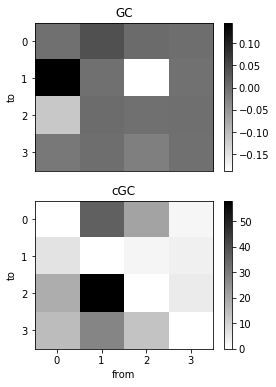

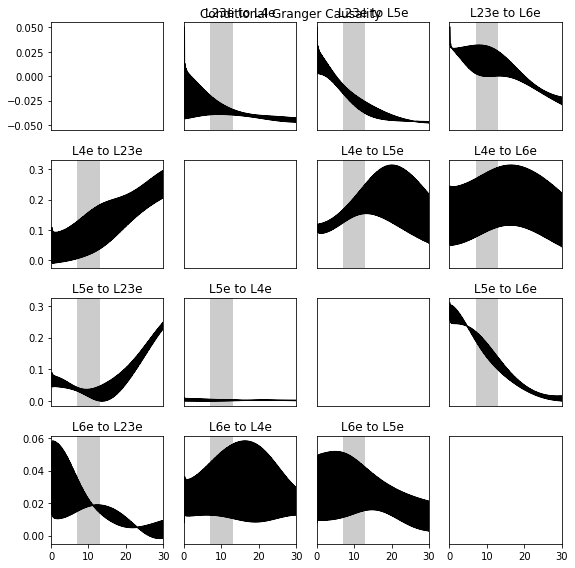

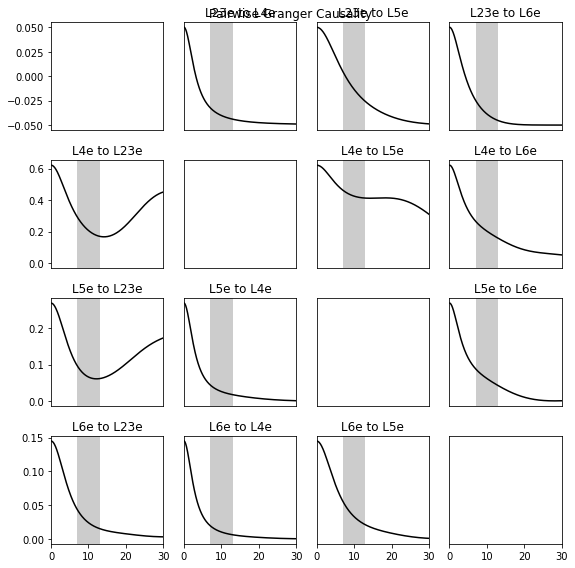

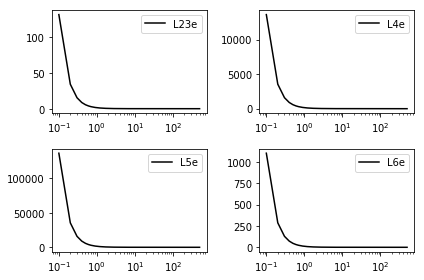

In [41]:
from scipy.integrate   import simps
print('Estimating pairwise Granger causalities:')
GC = np.zeros([Nvars, Nvars])
pGC = np.zeros([Nvars,Nvars,N//2+1])

for i in range(Nvars):
    for j in range(i, Nvars):
        if i == j:
            continue
        else:
            Saux = np.array([[S[i,i], S[i,j]],[S[j,i], S[j,j]]])
            Haux = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
            SIGaux = np.array([[SIG[i,i], SIG[i,j]],[SIG[j,i], SIG[j,j]]])
            Ix2y, Iy2x, _ = pygc.granger.granger_causality(Saux, Haux, SIGaux)
            pGC[i,j]= Ix2y
            pGC[j,i]= Iy2x
            GC[i,j] = simps(Ix2y, f) / 2*np.pi
            GC[j,i] = simps(Iy2x, f) / 2*np.pi

print('Estimating conditional Granger causalities:')
F   = pygc.granger.conditional_granger_causality(S, f, Fs, Niterations = 30, verbose=True)
cGC = pygc.granger.conditional_spec_granger_causality(S, f, Fs, Niterations=30, tol=1e-12, verbose=True)

print('Ploting figures:')

plt.figure(figsize=(4,6))
plt.subplot(2,1,1)
plt.imshow(F, aspect='auto', cmap='gist_yarg'); plt.colorbar()
plt.ylabel('to')
plt.title('GC')
plt.xticks([])
plt.subplot(2,1,2)
plt.imshow(GC.T, aspect='auto', cmap='gist_yarg'); plt.colorbar()
plt.ylabel('to')
plt.xlabel('from')
plt.title('cGC')
plt.savefig(dirname+'parametric_GC_conn.png', dpi=300)

plt.figure(figsize=(8,8))
count = 1
for i in range(Nvars):
    for j in range(Nvars):
        plt.subplot(Nvars, Nvars, count)
        if i==j:
            plt.plot()
        else:
            plt.plot(f,cGC[i,j], 'k')
            plt.title(pop_name[i] + ' to ' + pop_name[j])
            plt.axvspan(7.0, 13., facecolor='black', alpha=0.2)
        # plt.ylim(0,0.8)
        plt.xlim(0,30)
        if j > 0:
            plt.yticks([])
        if i < 3:
            plt.xticks([])
        count += 1
plt.suptitle('Conditional Granger Causality')
plt.tight_layout()
plt.savefig(dirname+'parametric_cGC.png', dpi=300)

plt.figure(figsize=(8,8))
count = 1
for i in range(Nvars):
    for j in range(Nvars):
        plt.subplot(Nvars, Nvars, count)
        if i==j:
            plt.plot()
        else:
            plt.plot(f,pGC[i,j], 'k')
            plt.title(pop_name[i] + ' to ' + pop_name[j])
            plt.axvspan(7.0, 13., facecolor='black', alpha=0.2)
        # plt.ylim(0,0.8)
        plt.xlim(0,30)
        if j > 0:
            plt.yticks([])
        if i < 3:
            plt.xticks([])
        count += 1
plt.suptitle('Pairwise Granger Causality')
plt.tight_layout()
plt.savefig(dirname+'parametric_pGC.png', dpi=300)

plt.figure()
count = 1
for i in range(Nvars):
    plt.subplot(2, 2, count)
    plt.semilogx(f,np.real(S[i,i]), 'k', label=pop_name[i])
    # plt.ylim(0,0.8)
    # plt.xlim(1,500)
    count += 1
    plt.legend()
plt.tight_layout()
plt.savefig(dirname+'parametric_power_spec.png', dpi=300)

plt.show()


In [43]:
X.shape

(4, 10000, 10)

In [48]:
X = X.swapaxes(0,1).swapaxes(0,-1)

In [104]:
N  = 10000      # Number of observations
Fs = 1000       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
Trials = 10    # Number of trials
freqs  = np.arange(1,150,1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

In [115]:
W = tf.wavelet_transform(data = X, fs = Fs, freqs = freqs, n_cycles = 3,
                         time_bandwidth = None, delta = 1, method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   4 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=40)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   4 out of   4 | elapsed:    4.8s finished


In [116]:
# Auto- and cross-spectra
S = np.zeros([X.shape[0], X.shape[1], X.shape[1], len(freqs), W.shape[-1]]) \
+ (1+1j)*np.zeros([X.shape[0], X.shape[1], X.shape[1], len(freqs), W.shape[-1]])
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        S[:,i,j] = W[:,i,:,:] * np.conj(W[:,j,:,:])/X.shape[-1]
# Average over trials
S_mu = S.mean(axis = 0)

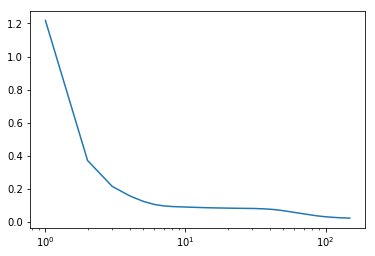

In [117]:
plt.semilogx(freqs, S_mu[0,0].real.sum(axis=-1))

In [111]:
np.diff(freqs)[0]

1

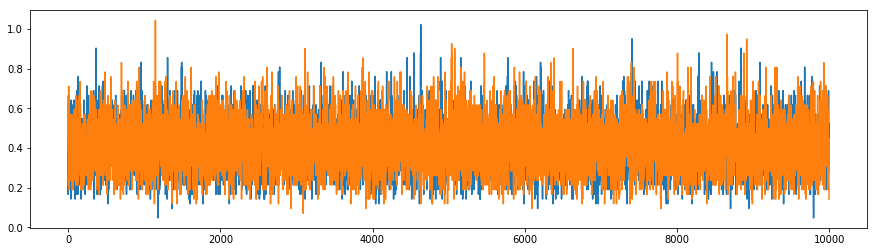

In [99]:
plt.figure(figsize=(15,4))
plt.plot(X[0,0])
plt.plot(X[9,0])